## Data Load

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv("../data/dataset.csv")
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


## EDA

In [148]:
from collections import Counter
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings

sns.set(style="whitegrid", palette='Dark2')
warnings.filterwarnings("ignore")

In [6]:
import nltk
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words("russian")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pavelkockin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
vc = data["toxic"].value_counts()
labels = ["Not Toxic", "Toxic"]

<AxesSubplot:>

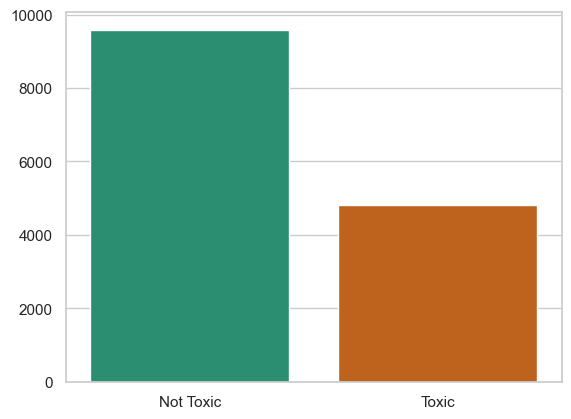

In [8]:
sns.barplot(x=labels, y=vc.values)

In [9]:
# Most frequent tokens for each tag
@widgets.interact(label=[0, 1])
def display_word_cloud(label: int = 1):
    plt.figure(figsize=(15, 5))
    subset = data[data["toxic"] == label]
    text = subset["comment"].values
    cloud = WordCloud(
        stopwords=STOPWORDS+['это'], background_color="white", collocations=False,
        width=500, height=300).generate(" ".join(text)
    )
    plt.axis("off")
    plt.imshow(cloud)

interactive(children=(Dropdown(description='label', index=1, options=(0, 1), value=1), Output()), _dom_classes…

## Preprocessing

In [10]:
from nltk.stem.snowball import SnowballStemmer 
import re

stemmer = SnowballStemmer("russian") 

In [20]:
from typing import List
def clean_text(text: str, lower: bool = True, stem: bool = False, stopwords: List[str] = STOPWORDS) -> str:
    """Clean raw data"""
    
    # Lower
    if lower:
        text = text.lower()
    
    # Remove stopwords
    if len(STOPWORDS):
        pattern = re.compile(r'\b(' + r"|".join(STOPWORDS) + r")\b\s*")
        text = pattern.sub('', text)
    
    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^А-Яа-яA-Za-z0-9]+", " ", text)  # remove non alphanumeric
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  # Remove links
    
    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word) for word in text.split(" ")])
    
    return text

In [12]:
data["comment"] = data["comment"].apply(clean_text, lower=True, stem=True)

In [13]:
data.head()

,comment,toxic
0,верблюд дебил бл,1.0
1,хохл эт отдушин затюкан россиянин мол вон хохл...,1.0
2,собак собач смерт,1.0
3,страниц обнов деб эт оскорблен доказа факт деб...,1.0
4,убед 6 страничн пдф скрипал отрав росс анализи...,1.0


In [14]:
X = data["comment"].to_numpy()
y = data["toxic"].to_numpy()

## Splitting data

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [17]:
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)

In [18]:
print(f"train shape: {X_train.shape}")
print(f"val shape: {X_val.shape}")
print(f"test shape: {X_test.shape}")

train shape: (10088,)
val shape: (2162,)
test shape: (2162,)


In [23]:
df_train = pd.DataFrame({"comment": X_train, "label": y_train})
df_val = pd.DataFrame({"comment": X_val, "label": y_val})
df_test = pd.DataFrame({"comment": X_test, "label": y_test})

## Modelling

In [95]:
import random
import numpy as np

def set_seed(seed: int = 73) -> None:
    """Set seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)

In [34]:
def preprocess(df: pd.DataFrame, lower: bool, stem: bool, preproc_col: str = "comment", ) -> pd.DataFrame:
    """Preprocess the data."""
    df[preproc_col] = df[preproc_col].apply(clean_text, lower=lower, stem=stem)  # clean text
    
    return df

In [35]:
def get_data_splits(X, y, train_size=0.7):
    """Generate balanced data splits."""
    
    X_train, X_, y_train, y_ = train_test_split(
        X, y, train_size=train_size, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(
        X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

### Baseline

In [36]:
from sklearn.metrics import classification_report

In [37]:
set_seed()
df = pd.read_csv("../data/dataset.csv")
df = preprocess(df, lower=True, stem=False)
X_train, X_val, X_test, y_train, y_val, y_test = get_data_splits(
    X=df["comment"].to_numpy(), 
    y=df["toxic"].to_numpy(),
)

In [46]:
# Generate random predictions
y_pred = np.random.randint(low=0, high=2, size=len(y_test))
print (y_pred.shape)
print (y_pred[0:5])

(2162,)
[1 1 0 1 1]


In [52]:
# Evaluate
metrics = classification_report(y_test, y_pred)
print(metrics)

              precision    recall  f1-score   support

         0.0       0.68      0.51      0.59      1438
         1.0       0.35      0.53      0.43       724

    accuracy                           0.52      2162
   macro avg       0.52      0.52      0.51      2162
weighted avg       0.57      0.52      0.53      2162



### Vectorization

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
# Tf-idf
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,7))  # char n-grams
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [61]:
# Class weights
counts = np.bincount(y_train.astype(int))
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [6710 3378],
class weights: {0: 0.00014903129657228018, 1: 0.0002960331557134399}


### Data Imbalanced

In [62]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(sampling_strategy="all")
X_over, y_over = oversampler.fit_resample(X_train, y_train)

In [64]:
# Class weights
counts = np.bincount(y_over.astype(int))
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [6710 6710],
class weights: {0: 0.00014903129657228018, 1: 0.00014903129657228018}


### Machine Learning

In [66]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, classification_report

In [70]:
# Initialize model
model = SGDClassifier(
    loss="log", penalty="l2", alpha=1e-4, max_iter=100,
    learning_rate="constant", eta0=1e-1, power_t=0.1, 
    warm_start=True
)

In [71]:
# Train model
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    model.fit(X_over, y_over)

    # Evaluation
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))

    if not epoch%10:
        print(
            f"Epoch: {epoch:02d} | "
            f"train_loss: {train_loss:.5f}, "
            f"val_loss: {val_loss:.5f}"
        )

Epoch: 00 | train_loss: 0.33131, val_loss: 0.39699
Epoch: 10 | train_loss: 0.32915, val_loss: 0.39605
Epoch: 20 | train_loss: 0.33191, val_loss: 0.39845
Epoch: 30 | train_loss: 0.32959, val_loss: 0.39641
Epoch: 40 | train_loss: 0.32866, val_loss: 0.39566
Epoch: 50 | train_loss: 0.33329, val_loss: 0.39966
Epoch: 60 | train_loss: 0.32985, val_loss: 0.39666
Epoch: 70 | train_loss: 0.33144, val_loss: 0.39803
Epoch: 80 | train_loss: 0.33097, val_loss: 0.39762
Epoch: 90 | train_loss: 0.32999, val_loss: 0.39679


In [79]:
# Evaluate
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

In [80]:
metrics = classification_report(y_test, y_pred)
print(metrics)

              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91      1438
         1.0       0.81      0.83      0.82       724

    accuracy                           0.88      2162
   macro avg       0.86      0.87      0.87      2162
weighted avg       0.88      0.88      0.88      2162



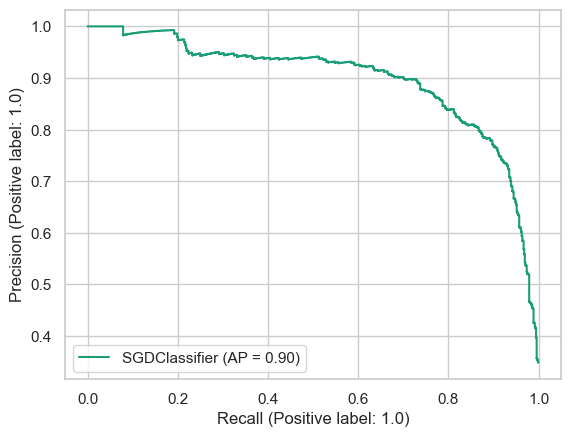

In [88]:
from sklearn.metrics import plot_precision_recall_curve


plot_precision_recall_curve(model, X_test, y_test)

<AxesSubplot:>

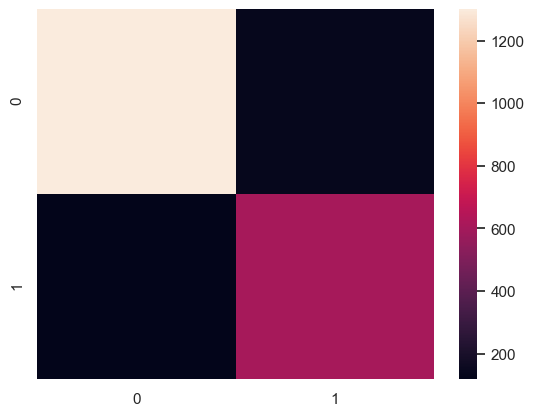

In [90]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred))

### Base pipeline

In [91]:
from sklearn.pipeline import Pipeline

base_pipe = Pipeline([
    ("vec", TfidfVectorizer(analyzer="char", ngram_range=(2,7))),
    ("clf", SGDClassifier(
        loss="log", penalty="l2", alpha=1e-4, max_iter=100,
        learning_rate="constant", eta0=1e-1, power_t=0.1, 
        warm_start=True),
    ),
])

### Experiment Tracking

In [96]:
from argparse import Namespace
import mlflow
from pathlib import Path
import optuna

In [93]:
# Specify arguments
args = Namespace(
    lower=True,
    stem=False,
    analyzer="char",
    ngram_max_range=7,
    alpha=1e-4,
    learning_rate=1e-1,
    power_t=0.1,
    num_epochs=100
)

In [94]:
# Set tracking URI
MODEL_REGISTRY = Path("experiments")
Path(MODEL_REGISTRY).mkdir(exist_ok=True) # create experiments dir
mlflow.set_tracking_uri("file://" + str(MODEL_REGISTRY.absolute()))

##### Trining

In [110]:
from sklearn.metrics import precision_recall_fscore_support
import json

def train(args, df, trial=None):
    """Train model on data."""

    # Setup
    set_seed()
    df = pd.read_csv("../data/dataset.csv")
    df = df.sample(frac=1).reset_index(drop=True)
    df = preprocess(df, lower=True, stem=False)
    X_train, X_val, X_test, y_train, y_val, y_test = get_data_splits(
        X=df["comment"].to_numpy(), 
        y=df["toxic"].to_numpy(),
    )

    # Tf-idf
    vectorizer = TfidfVectorizer(analyzer=args.analyzer, ngram_range=(2,args.ngram_max_range))  # char n-grams
    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)
    X_test = vectorizer.transform(X_test)

    # Oversample
    oversample = RandomOverSampler(sampling_strategy="all")
    X_over, y_over = oversample.fit_resample(X_train, y_train)

    # Model
    model = SGDClassifier(
        loss="log", penalty="l2", alpha=args.alpha, max_iter=100,
        learning_rate="constant", eta0=args.learning_rate, power_t=args.power_t, 
        warm_start=True
    )

    # Training
    for epoch in range(args.num_epochs):
        model.fit(X_over, y_over)
        train_loss = log_loss(y_train, model.predict_proba(X_train))
        val_loss = log_loss(y_val, model.predict_proba(X_val))
        if not epoch%10:
            print(
                f"Epoch: {epoch:02d} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}"
            )

        # Log
        if not trial:
            mlflow.log_metrics({"train_loss": train_loss, "val_loss": val_loss}, step=epoch)

        # Pruning (for optimization in next section)
        if trial:
            trial.report(val_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Evaluation
    y_pred = model.predict(X_test)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print(json.dumps(performance, indent=2))

    return {
        "args": args,
        "vectorizer": vectorizer,
        "model": model,
        "performance": performance
    }

##### Tracking

In [104]:
import joblib
import tempfile

In [105]:
# Set experiment
mlflow.set_experiment(experiment_name="baselines")

<Experiment: artifact_location='file:///Users/pavelkockin/main/github/russian-toxic-classification/notebooks/experiments/0', creation_time=1665607472200, experiment_id='0', last_update_time=1665607472200, lifecycle_stage='active', name='baselines', tags={}>

In [106]:
def save_dict(d, filepath):
    """Save dict to a json file."""
    with open(filepath, "w") as fp:
        json.dump(d, indent=2, sort_keys=False, fp=fp)

In [111]:
# Tracking
with mlflow.start_run(run_name="sgd"):

    # Train & evaluate
    artifacts = train(args=args, df=df)

    # Log key metrics
    mlflow.log_metrics({"precision": artifacts["performance"]["precision"]})
    mlflow.log_metrics({"recall": artifacts["performance"]["recall"]})
    mlflow.log_metrics({"f1": artifacts["performance"]["f1"]})

    # Log artifacts
    with tempfile.TemporaryDirectory() as dp:
        joblib.dump(artifacts["vectorizer"], Path(dp, "vectorizer.pkl"))
        joblib.dump(artifacts["model"], Path(dp, "model.pkl"))
        save_dict(artifacts["performance"], Path(dp, "performance.json"))
        mlflow.log_artifacts(dp)

    # Log parameters
    mlflow.log_params(vars(artifacts["args"]))

Epoch: 00 | train_loss: 0.33469, val_loss: 0.40684
Epoch: 10 | train_loss: 0.32785, val_loss: 0.40156
Epoch: 20 | train_loss: 0.32868, val_loss: 0.40232
Epoch: 30 | train_loss: 0.32860, val_loss: 0.40223
Epoch: 40 | train_loss: 0.33076, val_loss: 0.40425
Epoch: 50 | train_loss: 0.33006, val_loss: 0.40360
Epoch: 60 | train_loss: 0.33108, val_loss: 0.40461
Epoch: 70 | train_loss: 0.33272, val_loss: 0.40616
Epoch: 80 | train_loss: 0.32899, val_loss: 0.40260
Epoch: 90 | train_loss: 0.32759, val_loss: 0.40130
{
  "precision": 0.8770514810334724,
  "recall": 0.8769657724329325,
  "f1": 0.8770078142201942
}


##### Loading for retraining

In [112]:
def load_dict(filepath):
    """Load a dict from a json file."""
    with open(filepath, "r") as fp:
        d = json.load(fp)
    return d

In [113]:
# Load all runs from experiment
experiment_id = mlflow.get_experiment_by_name("baselines").experiment_id
all_runs = mlflow.search_runs(experiment_ids=experiment_id, order_by=["metrics.val_loss ASC"])
print (all_runs)

                             run_id experiment_id    status  \
0  d9a779197c744ebc90ab2adea803dcb7             0  FINISHED   
1  77134de52471465280b715a2fec44790             0    FAILED   
2  e8dd1e5db4ad43bda6f0aec6bf9e58cc             0    FAILED   
3  77a58c0755b1435aaa4eac23fff326ff             0    FAILED   
4  2544b4e758ea471db580b908b8d34f2c             0    FAILED   

                                        artifact_uri  \
0  file:///Users/pavelkockin/main/github/russian-...   
1  file:///Users/pavelkockin/main/github/russian-...   
2  file:///Users/pavelkockin/main/github/russian-...   
3  file:///Users/pavelkockin/main/github/russian-...   
4  file:///Users/pavelkockin/main/github/russian-...   

                        start_time                         end_time  \
0 2022-10-12 20:47:32.004000+00:00 2022-10-12 20:48:05.606000+00:00   
1 2022-10-12 20:46:15.436000+00:00 2022-10-12 20:46:45.607000+00:00   
2 2022-10-12 20:46:03.901000+00:00 2022-10-12 20:46:03.905000+00:00   


In [114]:
# Best run
best_run_id = all_runs.iloc[0].run_id
best_run = mlflow.get_run(run_id=best_run_id)
client = mlflow.tracking.MlflowClient()
with tempfile.TemporaryDirectory() as dp:
    client.download_artifacts(run_id=best_run_id, path="", dst_path=dp)
    vectorizer = joblib.load(Path(dp, "vectorizer.pkl"))
    model = joblib.load(Path(dp, "model.pkl"))
    performance = load_dict(filepath=Path(dp, "performance.json"))

In [115]:
print (json.dumps(performance, indent=2))

{
  "precision": 0.8770514810334724,
  "recall": 0.8769657724329325,
  "f1": 0.8770078142201942
}


In [121]:
# Inference
text = "Ты кто такой?"
text = clean_text(text)
vec = vectorizer.transform([text])
model.predict(vec)

array([1.])

### Optimization

In [122]:
def objective(args, trial):
    """Objective function for optimization trials."""
    # Parameters to tune
    args.analyzer = trial.suggest_categorical("analyzer", ["word", "char", "char_wb"])
    args.ngram_max_range = trial.suggest_int("ngram_max_range", 3, 10)
    args.learning_rate = trial.suggest_loguniform("learning_rate", 1e-2, 1e0)
    args.power_t = trial.suggest_uniform("power_t", 0.1, 0.5)

    # Train & evaluate
    artifacts = train(args=args, df=df, trial=trial)

    # Set additional attributes
    performance = artifacts["performance"]
    print(json.dumps(performance, indent=2))
    trial.set_user_attr("precision", performance["precision"])
    trial.set_user_attr("recall", performance["recall"])
    trial.set_user_attr("f1", performance["f1"])

    return performance["f1"]

In [126]:
# from numpyencoder import NumpyEncoder
from optuna.integration.mlflow import MLflowCallback

In [127]:
NUM_TRIALS = 20  # small sample for now

In [ ]:
# Optimize
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study = optuna.create_study(study_name="optimization", direction="maximize", pruner=pruner)

mlflow_callback = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(), 
    metric_name="f1"
)

study.optimize(
    lambda trial: objective(args, trial),
    n_trials=NUM_TRIALS,
    callbacks=[mlflow_callback]
)

In [129]:
# Best trial
print (f"Best value (f1): {study.best_trial.value}")
print (f"Best hyperparameters: {json.dumps(study.best_trial.params, indent=2)}")

Best value (f1): 0.8913066234496378
Best hyperparameters: {
  "analyzer": "char_wb",
  "ngram_max_range": 7,
  "learning_rate": 0.06127088055877166,
  "power_t": 0.30272621118441834
}
